# This notebook demonstrates using nested cv for hyperparameter tuning
We will fetch the dataset from UCI Machine Learning Repository using ucimlrepo package

# Load in the data

In [12]:
from sklearn import tree # for decision tree
from sklearn import linear_model # for logistic regression
from sklearn import neighbors # for kNN
from sklearn import svm # for SVM
from sklearn import naive_bayes # for NB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, StackingClassifier # for ensembling model

import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split, cross_validate, GridSearchCV, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt
# from matplotlib.colors import ListedColormap

import scikitplot as skplt # will be used in skplt.metrics.plot_lift_curve

# I've checked that we can appropriately ignore some warnings here
import warnings
warnings.filterwarnings('ignore')

In [13]:
# !pip install ucimlrepo
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
spambase = fetch_ucirepo(id=94) 
  
# data (as pandas dataframes) 
X = spambase.data.features 
y = spambase.data.targets 

### Print out the metadata and variable information

In [16]:
# metadata 
spambase.metadata

{'uci_id': 94,
 'name': 'Spambase',
 'repository_url': 'https://archive.ics.uci.edu/dataset/94/spambase',
 'data_url': 'https://archive.ics.uci.edu/static/public/94/data.csv',
 'abstract': 'Classifying Email as Spam or Non-Spam',
 'area': 'Computer Science',
 'tasks': ['Classification'],
 'characteristics': ['Multivariate'],
 'num_instances': 4601,
 'num_features': 57,
 'feature_types': ['Integer', 'Real'],
 'demographics': [],
 'target_col': ['Class'],
 'index_col': None,
 'has_missing_values': 'no',
 'missing_values_symbol': None,
 'year_of_dataset_creation': 1999,
 'last_updated': 'Mon Aug 28 2023',
 'dataset_doi': '10.24432/C53G6X',
 'creators': ['Mark Hopkins',
  'Erik Reeber',
  'George Forman',
  'Jaap Suermondt'],
 'intro_paper': None,
 'additional_info': {'summary': 'The "spam" concept is diverse: advertisements for products/web sites, make money fast schemes, chain letters, pornography...\n\nThe classification task for this dataset is to determine whether a given email is spa

In [17]:
# variable information 
spambase.variables

,name,role,type,demographic,description,units,missing_values
0,word_freq_make,Feature,Continuous,None,None,None,no
1,word_freq_address,Feature,Continuous,None,None,None,no
2,word_freq_all,Feature,Continuous,None,None,None,no
3,word_freq_3d,Feature,Continuous,None,None,None,no
4,word_freq_our,Feature,Continuous,None,None,None,no
5,word_freq_over,Feature,Continuous,None,None,None,no
6,word_freq_remove,Feature,Continuous,None,None,None,no
7,word_freq_internet,Feature,Continuous,None,None,None,no
8,word_freq_order,Feature,Continuous,None,None,None,no
9,word_freq_mail,Feature,Continuous,None,None,None,no


### Some important recap: 
1. Label: spam (1) or not (0).
2. False positives, i.e. marking good mail(0) as spam(1), are very undesirable.  
   If insisting on zero false positives in the training/testing set, 20-25% of the spam passed through the filter (mentioned above).  
3. All the variables are continuous, i.e., numerical variables, with a binary target variable.  
4. There's no missing value in the dataset.  

# Data pre-processing

### Checking whether having severe imbalance data problem

In [18]:
# check the proportion of the target variable
y.value_counts()

Class
0        2788
1        1813
Name: count, dtype: int64

In [19]:
# print out the proportion of the minority class, label 1 here
y.value_counts()[1] / (y.value_counts()[0] + y.value_counts()[1])

0.39404477287546186

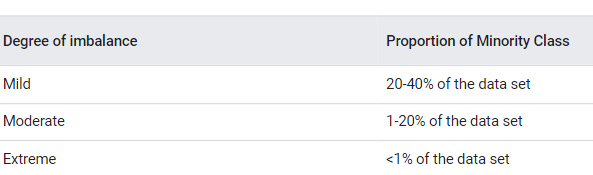

The table above is from Google machine learning foundational courses:  
https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data  

According to it, there's a relatively mild imbalance problem, I would skip adjustment here.  

### Training-testing split

In [20]:
# split the dataset into a training set() and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 30)

# 'random_state' ensures reproducibility; it's a random seed

### Max-min normalization

In [22]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train) # use fit_transform for training set
X_test_scaled = scaler.transform(X_test) # use transform for testing set

# transform: can use the same mean and variance as it is calculated from our training data to transform our test data

# Model fitting: use nested CV for hyperparameter tunung

I selected optimized hyperparameter in the GridSearch phase, then do model performance comparison on RMSE using nested cv.  
Note that I also utilized bagging strategy for each basic learner to implement ensembling model.  

Therefore the working setps will be:
1. use GridSearch in inner cv loop to find optimized for each basic learner  
2. use bagging strategy for each optimized basic learner 
3. calculate misclassification cost for each optimized basic learner  
4. use cross-validation in outer cv loop and print mean, standard deviation, mean misclassification cost
5. also apply boosting and stacking ensembling strategies other than this nested CV
5. report performances for all the model

### Set up all the arguments and arrays

In [29]:
# number of random trials
num_trails = 3

# set up possible values of parameters to optimize over
dt_grid = {'criterion': ['entropy'], 'max_depth': list(range(5, 20))}
lr_grid = {'penalty': ['l1', 'l2', 'elasticnet'], 'C': [1e5, 1e4, 1e3, 100, 1], 'multi_class': ['multinomial'], 'solver': ['saga'], 'l1_ratio': [0, 0.5, 1]}
knn_grid = {'n_neighbors': list(range(1, 31))}
nb_grid = {'var_smoothing': [1e-5, 1e-4, 1e-3, 0.01, 0.1, 1, 10]}
# note that I have 3 dictionaries of hyperparameters for svm
svm_tuned_parameters = [{'kernel': ['rbf'], 'C': [100, 10, 1, 0.1]}]

# set up estimator
dt = tree.DecisionTreeClassifier()
lr = linear_model.LogisticRegression()
knn = neighbors.KNeighborsClassifier()
nb = naive_bayes.GaussianNB()
svc = svm.SVC()

# arrays to store nested scores
dt_scores = np.zeros(num_trails)
lr_scores = np.zeros(num_trails)
knn_scores = np.zeros(num_trails)
nb_scores = np.zeros(num_trails)
svm_scores = np.zeros(num_trails)

# arrays to store nested scores in bagging
Bdt_scores = np.zeros(num_trails)
Blr_scores = np.zeros(num_trails)
Bknn_scores = np.zeros(num_trails)
Bnb_scores = np.zeros(num_trails)
Bsvm_scores = np.zeros(num_trails)

# arrays to store misclassification cost
mis_dt_scores = np.zeros(num_trails)
mis_lr_scores = np.zeros(num_trails)
mis_knn_scores = np.zeros(num_trails)
mis_nb_scores = np.zeros(num_trails)
mis_svm_scores = np.zeros(num_trails)

# arrays to store misclassification cost in bagging
Bmis_dt_scores = np.zeros(num_trails)
Bmis_lr_scores = np.zeros(num_trails)
Bmis_knn_scores = np.zeros(num_trails)
Bmis_nb_scores = np.zeros(num_trails)
Bmis_svm_scores = np.zeros(num_trails)

# gradient boosting regression scores
gbr_scores = np.zeros(num_trails)
# gradient boosting regression misclassification cost
mis_gbr_scores = np.zeros(num_trails)

# set scoring 
scoring = 'accuracy'

### Try ensembling modeling: bagging
I embedded this function to also generate score through bagging for each model

In [24]:
# define function for ensembling model: bagging

def bagging(basic_learner):
    bag_clf = BaggingClassifier(basic_learner, n_estimators=500, max_samples=100, n_jobs=-1, oob_score=True)
    bag_clf.fit(X_train_scaled, y_train)
    
    return bag_clf

### Calculate misclassification cost
I embedded this function to also generate misclassification cost through bagging for each model

In [25]:
# define function for misclassification cost computing

def misclassification_cost(trained_classifier):
    y_train_pred = trained_classifier.predict(X_train_scaled)
    # extract metrics for computing cost-sensitive measure
    tn, fp, fn, tp = confusion_matrix(y_train, y_train_pred).ravel()
    cost = 10*fp + 1*fn # fp is very undesirable
    
    return cost

### Run the nested cross-vallidation

In [14]:
# note that for GridSearchCV, the argument 'refit' is True by default, so the optimized parameter will be fitted and retured

# appropriately ignore some warnings
import warnings
warnings.filterwarnings("ignore", message="l1_ratio parameter is only used when penalty is ")
warnings.filterwarnings("ignore", message="The max_iter was reached which means ")

for i in range(num_trails): 
    # choose cross-validation techniques for the inner and outer loops
    # e.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
    inner_cv = KFold(n_splits = 5, shuffle = True, random_state = i)
    outer_cv = KFold(n_splits = 5, shuffle = True, random_state = i)

    # non-nested parameter search and scoring
    print('==================================================================')
    print('In GridSearch to find optimized hyperparameters: trail', i+1, '\n')
    
    dt_clf = GridSearchCV(estimator = dt, param_grid = dt_grid, scoring = scoring, cv = inner_cv, refit = True)
    dt_clf.fit(X_train_scaled, y_train)
    print('Decision Tree')
    print("Best Hyperparameters: ", dt_clf.best_params_)
    print("Best Accuracy: ", dt_clf.best_score_)
    m1 = misclassification_cost(dt_clf)
    print('Misclassification cost: ', m1)
    b1 = bagging(dt_clf)
    print('Bagging score of out-of-bag estimate: ', b1.oob_score_) # only works when oob_score=True
    bm1 = misclassification_cost(b1)
    print('Misclassification cost after bagging: ', bm1)
    
    lr_clf = GridSearchCV(estimator = lr, param_grid = lr_grid, scoring = scoring, cv = inner_cv, refit = True)
    lr_clf.fit(X_train_scaled, y_train)
    print('\nLogistic Regression')
    print("Best Hyperparameters: ", lr_clf.best_params_)
    print("Best Accuracy: ", lr_clf.best_score_)
    m2 = misclassification_cost(lr_clf)
    print('Misclassification cost: ', m2)
    b2 = bagging(lr_clf)
    print('Bagging score of out-of-bag estimate: ', b2.oob_score_) # only works when oob_score=True
    bm2 = misclassification_cost(b2)
    print('Misclassification cost after bagging: ', bm2)
    
    knn_clf = GridSearchCV(estimator = knn, param_grid = knn_grid, scoring = scoring, cv = inner_cv, refit = True)
    knn_clf.fit(X_train_scaled, y_train)
    print('\nKNN')
    print("Best Hyperparameters: ", knn_clf.best_params_)
    print("Best Accuracy: ", knn_clf.best_score_)
    m3 = misclassification_cost(knn_clf)
    print('Misclassification cost: ', m3)
    b3 = bagging(knn_clf)
    print('Bagging score of out-of-bag estimate: ', b3.oob_score_) # only works when oob_score=True
    bm3 = misclassification_cost(b3)
    print('Misclassification cost after bagging: ', bm3)
    
    nb_clf = GridSearchCV(estimator = nb, param_grid = nb_grid, scoring = scoring, cv = inner_cv, refit = True)
    nb_clf.fit(X_train_scaled, y_train)
    print('\nGaussian Naive Bayes')
    print("Best Hyperparameters: ", nb_clf.best_params_)
    print("Best Accuracy: ", nb_clf.best_score_)
    m4 = misclassification_cost(nb_clf)
    print('Misclassification cost: ', m4)
    b4 = bagging(nb_clf)
    print('Bagging score of out-of-bag estimate: ', b4.oob_score_) # only works when oob_score=True
    bm4 = misclassification_cost(b4)
    print('Misclassification cost after bagging: ', bm4)

    svm_clf = GridSearchCV(estimator = svc, param_grid = svm_tuned_parameters, scoring = scoring, cv = inner_cv, refit = True)    
    svm_clf.fit(X_train_scaled, y_train)
    print('\nSVM')
    print("Best Hyperparameters: ", svm_clf.best_params_)
    print("Best Accuracy: ", svm_clf.best_score_)
    m5 = misclassification_cost(svm_clf)
    print('Misclassification cost: ', m5)
    b5 = bagging(svm_clf)
    print('Bagging score of out-of-bag estimate: ', b5.oob_score_) # only works when oob_score=True
    bm5 = misclassification_cost(b5)
    print('Misclassification cost after bagging: ', bm5)
    
    
    # nested cv with parameter opitmization
    dt_score = cross_val_score(dt_clf, X_train_scaled, y_train, cv = outer_cv)
    dt_scores[i] = dt_score.mean()
    mis_dt_scores[i] = m1
    
    lr_score = cross_val_score(lr_clf, X_train_scaled, y_train, cv = outer_cv)
    lr_scores[i] = lr_score.mean()
    mis_lr_scores[i] = m2
    
    knn_score = cross_val_score(knn_clf, X_train_scaled, y_train, cv = outer_cv)
    knn_scores[i] = knn_score.mean()
    mis_knn_scores[i] = m3
    
    nb_score = cross_val_score(nb_clf, X_train_scaled, y_train, cv = outer_cv)
    nb_scores[i] = nb_score.mean()
    mis_nb_scores[i] = m4
    
    svm_score = cross_val_score(svm_clf, X_train_scaled, y_train, cv = outer_cv)
    svm_scores[i] = svm_score.mean()
    mis_svm_scores[i] = m5
    
    
    # nested cv with parameter opitmization: in bagging
    dt_score = cross_val_score(bagging(dt_clf), X_train_scaled, y_train, cv = outer_cv)
    Bdt_scores[i] = dt_score.mean()
    Bmis_dt_scores[i] = bm1
    
    lr_score = cross_val_score(bagging(lr_clf), X_train_scaled, y_train, cv = outer_cv)
    Blr_scores[i] = lr_score.mean()
    Bmis_lr_scores[i] = bm2
    
    knn_score = cross_val_score(bagging(knn_clf), X_train_scaled, y_train, cv = outer_cv)
    Bknn_scores[i] = knn_score.mean()
    Bmis_knn_scores[i] = bm3
    
    nb_score = cross_val_score(bagging(nb_clf), X_train_scaled, y_train, cv = outer_cv)
    Bnb_scores[i] = nb_score.mean()
    Bmis_nb_scores[i] = bm4
    
    svm_score = cross_val_score(bagging(svm_clf), X_train_scaled, y_train, cv = outer_cv)
    Bsvm_scores[i] = svm_score.mean()
    Bmis_svm_scores[i] = bm5

In GridSearch to find optimized hyperparameters: trail 1 

Decision Tree
Best Hyperparameters:  {'criterion': 'entropy', 'max_depth': 10}
Best Accuracy:  0.9149068322981367
Misclassification cost:  501
Bagging score of out-of-bag estimate:  0.9236024844720497
Misclassification cost after bagging:  847

Logistic Regression
Best Hyperparameters:  {'C': 10000.0, 'l1_ratio': 0, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'saga'}
Best Accuracy:  0.9229813664596274
Misclassification cost:  1015
Bagging score of out-of-bag estimate:  0.9083850931677019
Misclassification cost after bagging:  1368

KNN
Best Hyperparameters:  {'n_neighbors': 3}
Best Accuracy:  0.8950310559006212
Misclassification cost:  856
Bagging score of out-of-bag estimate:  0.8400621118012422
Misclassification cost after bagging:  1474

Gaussian Naive Bayes
Best Hyperparameters:  {'var_smoothing': 0.0001}
Best Accuracy:  0.8186335403726709
Misclassification cost:  5379
Bagging score of out-of-bag estimate:  0.8

### Try ensembling model: gradient boosting classifier

In [34]:
# The basic learner of gradient boosting classifier is decision tree
# using GridSearch to find optimized hyperparameters

boosting_grid = {'learning_rate': [10, 1, 0.1], 'n_estimators': [300], 'max_depth': [20]}
gbr = GradientBoostingClassifier(warm_start = True)
# warm_start = True: reuse the solution of the previous call to fit and add more estimators to the ensemble

for i in range(num_trails): 
    print('==================================================================')
    print('In GridSearch to find optimized hyperparameters: trail', i+1, '\n')
    
    gbr_clf = GridSearchCV(estimator = gbr, param_grid = boosting_grid, scoring = 'accuracy', cv = 5, refit = True)    
    gbr_clf.fit(X_train_scaled, y_train)
    print("Best Hyperparameters: ", gbr_clf.best_params_)
    print("Best Accuracy: ", gbr_clf.best_score_)
    mb = misclassification_cost(gbr_clf)
    print('Misclassification cost: ', mb)

    # then do cross validation for gradient boosting classifier
    gbr_score = cross_val_score(gbr_clf, X_train_scaled, y_train, scoring = 'accuracy', cv = 5)
    gbr_scores[i] = gbr_score.mean()
    mis_gbr_scores[i] = mb

In GridSearch to find optimized hyperparameters: trail 1 

Best Hyperparameters:  {'learning_rate': 1, 'max_depth': 20, 'n_estimators': 300}
Best Accuracy:  0.9385093167701862
Misclassification cost:  10
In GridSearch to find optimized hyperparameters: trail 2 

Best Hyperparameters:  {'learning_rate': 1, 'max_depth': 20, 'n_estimators': 300}
Best Accuracy:  0.9357142857142857
Misclassification cost:  1
In GridSearch to find optimized hyperparameters: trail 3 

Best Hyperparameters:  {'learning_rate': 1, 'max_depth': 20, 'n_estimators': 300}
Best Accuracy:  0.9425465838509318
Misclassification cost:  1


In [35]:
print('Mean of gradient boosting classifier scores: ', gbr_scores.mean())
print('Standard deviation of gradient boosting classifier scores: ', round(gbr_scores.std(), 6))

# misclassification cost
print('Mean of misclassification cost: ', mis_gbr_scores.mean())

Mean of gradient boosting classifier scores:  0.9373706004140786
Standard deviation of gradient boosting classifier scores:  0.000293
Mean of misclassification cost:  4.0


### Try ensembling modeling: stacking

In [33]:
# define estimators
estimators_list = [('rf', RandomForestClassifier()), 
                   ('svc', svm.SVC()),
                   ('knn', neighbors.KNeighborsClassifier())]

# define stacking classifier, using logistic regression as final classifier
sclf = StackingClassifier(estimators = estimators_list, final_estimator = linear_model.LogisticRegression(), passthrough = False)

# define hyperparameters to tune
# use default kernel 'rbf' for svc
params = {'knn__n_neighbors': [2, 3, 4, 5],
          'svc__C': [100, 10, 1],
          'rf__n_estimators': [30, 40, 50], 
          'final_estimator__C': [0.1, 1.0, 10.0]
         }

grid = GridSearchCV(estimator=sclf, param_grid=params, cv=5, refit=True)
grid.fit(X_train_scaled, y_train)

cv_keys = ('mean_test_score', 'std_test_score', 'params')

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_[cv_keys[0]][r],
             grid.cv_results_[cv_keys[1]][r] / 2.0,
             grid.cv_results_[cv_keys[2]][r]))

print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)
print('Misclassification cost: ', misclassification_cost(grid))

0.948 +/- 0.00 {'final_estimator__C': 0.1, 'knn__n_neighbors': 2, 'rf__n_estimators': 30, 'svc__C': 100}
0.948 +/- 0.00 {'final_estimator__C': 0.1, 'knn__n_neighbors': 2, 'rf__n_estimators': 30, 'svc__C': 10}
0.949 +/- 0.00 {'final_estimator__C': 0.1, 'knn__n_neighbors': 2, 'rf__n_estimators': 30, 'svc__C': 1}
0.949 +/- 0.00 {'final_estimator__C': 0.1, 'knn__n_neighbors': 2, 'rf__n_estimators': 40, 'svc__C': 100}
0.950 +/- 0.00 {'final_estimator__C': 0.1, 'knn__n_neighbors': 2, 'rf__n_estimators': 40, 'svc__C': 10}
0.950 +/- 0.00 {'final_estimator__C': 0.1, 'knn__n_neighbors': 2, 'rf__n_estimators': 40, 'svc__C': 1}
0.949 +/- 0.00 {'final_estimator__C': 0.1, 'knn__n_neighbors': 2, 'rf__n_estimators': 50, 'svc__C': 100}
0.949 +/- 0.00 {'final_estimator__C': 0.1, 'knn__n_neighbors': 2, 'rf__n_estimators': 50, 'svc__C': 10}
0.948 +/- 0.01 {'final_estimator__C': 0.1, 'knn__n_neighbors': 2, 'rf__n_estimators': 50, 'svc__C': 1}
0.949 +/- 0.00 {'final_estimator__C': 0.1, 'knn__n_neighbors': 3

### Print out the result:

In [17]:
print('In nested CV:\n')
print('Mean of decision tree score in nested cv: ', dt_scores.mean())
print('Mean of logistic regression score in nested cv: ', lr_scores.mean())
print('Mean of kNN score in nested cv: ', knn_scores.mean())
print('Mean of NB score in nested cv: ', nb_scores.mean())
print('Mean of SVM score in nested cv: ', svm_scores.mean())

In nested CV:

Mean of decision tree score in nested cv:  0.9106625258799173
Mean of logistic regression score in nested cv:  0.9225672877846791
Mean of kNN score in nested cv:  0.8934782608695652
Mean of NB score in nested cv:  0.8186335403726709
Mean of SVM score in nested cv:  0.9318840579710145


In [18]:
print('In nested CV:\n')
print('Standard deviation of decision tree score in nested cv: ', round(dt_scores.std(), 6))
print('Standard deviation of logistic regression score in nested cv: ', round(lr_scores.std(), 6))
print('Standard deviation of kNN score in nested cv: ', round(knn_scores.std(), 6))
print('Standard deviation of NB score in nested cv: ', round(nb_scores.std(), 6))
print('Standard deviation of SVM score in nested cv: ', svm_scores.std()) # this is too small, approximately 0

In nested CV:

Standard deviation of decision tree score in nested cv:  0.001276
Standard deviation of logistic regression score in nested cv:  0.001549
Standard deviation of kNN score in nested cv:  0.001775
Standard deviation of NB score in nested cv:  0.001162
Standard deviation of SVM score in nested cv:  0.0008151146867507634


### Print out the result in bagging:

In [19]:
print('In nested CV with bagging:\n')
print('Mean of decision tree score in nested cv: ', Bdt_scores.mean())
print('Mean of logistic regression score in nested cv: ', Blr_scores.mean())
print('Mean of kNN score in nested cv: ', Bknn_scores.mean())
print('Mean of NB score in nested cv: ', Bnb_scores.mean())
print('Mean of SVM score in nested cv: ', Bsvm_scores.mean())

In nested CV with bagging:

Mean of decision tree score in nested cv:  0.9218426501035196
Mean of logistic regression score in nested cv:  0.9082815734989648
Mean of kNN score in nested cv:  0.8407867494824016
Mean of NB score in nested cv:  0.8531055900621117
Mean of SVM score in nested cv:  0.9002070393374743


In [20]:
print('In nested CV with bagging:\n')
print('Standard deviation of decision tree score in nested cv: ', round(Bdt_scores.std(), 6))
print('Standard deviation of logistic regression score in nested cv: ', round(Blr_scores.std(), 6))
print('Standard deviation of kNN score in nested cv: ', round(Bknn_scores.std(), 6))
print('Standard deviation of NB score in nested cv: ', round(Bnb_scores.std(), 6))
print('Standard deviation of SVM score in nested cv: ', Bsvm_scores.std())

In nested CV with bagging:

Standard deviation of decision tree score in nested cv:  0.000586
Standard deviation of logistic regression score in nested cv:  0.000891
Standard deviation of kNN score in nested cv:  0.001056
Standard deviation of NB score in nested cv:  0.000671
Standard deviation of SVM score in nested cv:  0.0011434121135805077


### Print out the result for misclassification calculating:

In [25]:
print('In nested CV:\n')
print('Mean of decision tree cost in nested cv: ', mis_dt_scores.mean())
print('Mean of logistic regression cost in nested cv: ', mis_lr_scores.mean())
print('Mean of kNN cost in nested cv: ', mis_knn_scores.mean())
print('Mean of NB cost in nested cv: ', mis_nb_scores.mean())
print('Mean of SVM cost in nested cv: ', mis_svm_scores.mean())

In nested CV:

Mean of decision tree cost in nested cv:  388.6666666666667
Mean of logistic regression cost in nested cv:  1023.3333333333334
Mean of kNN cost in nested cv:  292.0
Mean of NB cost in nested cv:  5379.0
Mean of SVM cost in nested cv:  423.0


In [26]:
print('In nested CV with bagging:\n')
print('Mean of decision tree cost in nested cv: ', Bmis_dt_scores.mean())
print('Mean of logistic regression cost in nested cv: ', Bmis_lr_scores.mean())
print('Mean of kNN cost in nested cv: ', Bmis_knn_scores.mean())
print('Mean of NB cost in nested cv: ', Bmis_nb_scores.mean())
print('Mean of SVM cost in nested cv: ', Bmis_svm_scores.mean())

In nested CV with bagging:

Mean of decision tree cost in nested cv:  859.3333333333334
Mean of logistic regression cost in nested cv:  1352.3333333333333
Mean of kNN cost in nested cv:  1492.6666666666667
Mean of NB cost in nested cv:  4225.333333333333
Mean of SVM cost in nested cv:  945.6666666666666


### Report the best models in (1) overall predictive accuracy, (2) accuracy considering cost-sensitive

1. Interms of overall predictive accuracy, for stronger learners (i.e., more complicated model), like logistic regression and SVM, bagging didn't help improving accuracy since they are stable, yet bagging helped almost all the models to decrease variation, i.e., generate lower standard deviation.  
2. Interms of overall predictive accuracy, stacking has the best result, with accuracy be 0.9413.  
3. Interms of best cost-sensitive model, gradient boosting classification gives the best result, with average misclassification cost be 4 units (if set cost of fp:fn = 10 units:1 unit), which is much better than all other models.  
4. Then we also want to check other metrics to make sure the result is reliable, so see the following sections.

# Report best model performance in testing set

### Visualize the best model performances on testing set: stacking

accuracy: 0.941346850108617

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.95       863
           1       0.94      0.90      0.92       518

    accuracy                           0.94      1381
   macro avg       0.94      0.93      0.94      1381
weighted avg       0.94      0.94      0.94      1381


Confusion Matrix:
 [[835  28]
 [ 53 465]]
ROC-AUC Score: 0.9326192191197984


<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

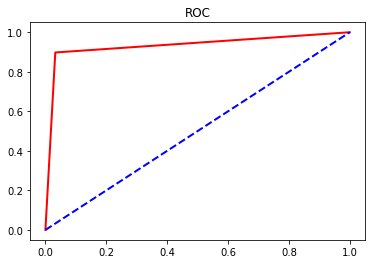

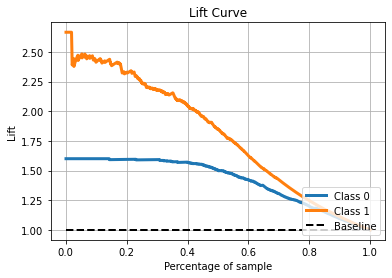

In [39]:
# generate prediction on testing set
y_pred = grid.predict(X_test_scaled)

# prepare the confusion matrix
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)

print("accuracy:", accuracy)
print("\nClassification Report:\n", report)
print("\nConfusion Matrix:\n", confusion)
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)  # Replace y_pred with predicted probabilities
roc_auc = auc(fpr, tpr)
print("ROC-AUC Score:", roc_auc)

# plot the ROC curve
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.title('ROC')

# plot the lift curve
y_probas = grid.predict_proba(X_test) # use the classifier to predict probabilities on the test set
skplt.metrics.plot_lift_curve(y_test, y_probas, title='Lift Curve') # plot the lift curve

### Visualize the best model performances on testing set: gradient boosting classification

accuracy: 0.939898624185373

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.95       863
           1       0.94      0.90      0.92       518

    accuracy                           0.94      1381
   macro avg       0.94      0.93      0.94      1381
weighted avg       0.94      0.94      0.94      1381


Confusion Matrix:
 [[834  29]
 [ 54 464]]
ROC-AUC Score: 0.9310745938787653


<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

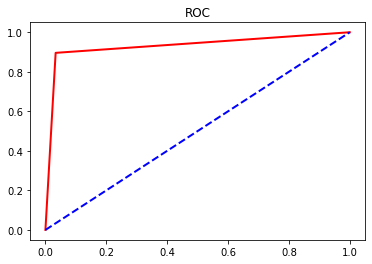

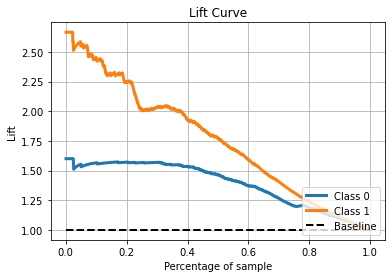

In [38]:
# generate prediction on testing set
y_pred = gbr_clf.predict(X_test_scaled)

# prepare the confusion matrix
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)

print("accuracy:", accuracy)
print("\nClassification Report:\n", report)
print("\nConfusion Matrix:\n", confusion)
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)  # Replace y_pred with predicted probabilities
roc_auc = auc(fpr, tpr)
print("ROC-AUC Score:", roc_auc)

# plot the ROC curve
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.title('ROC')

# plot the lift curve
y_probas = gbr_clf.predict_proba(X_test) # use the classifier to predict probabilities on the test set
skplt.metrics.plot_lift_curve(y_test, y_probas, title='Lift Curve') # plot the lift curve

### Report the best models in other metrics

Note that both models also have good AUC, 0.9326 and 0.9310, respectively.  
And other metrics also present high performance.  
Therefore, the result is reliable.

# Final conclusion
1. Model with best overall predictive accuracy: stacking, accuracy = 0.9413  
Best parameters for each basic learner:  
n_neighbors for knn: 5, n_estimators for RandomForestClassifier: 50, C for SVC: 10, C for logistic regression (final classifier): 10.0  


2. Best cost-sensitive classification model: gradient boosting classification, average misclassification cost = 4 (set cost fp:fn = 10:1)  
Therefore, it has the best ability to avoid false positive, that is, classifying non-spam email as spam.  
One can note that it also presents a good accuracy = 0.937